# ClickRateAnalysis (single site) - Snapping shrimp clicks/sec

This notebook scans WAV files in a folder (recursive), optionally filters by date range and/or selects a fixed number of files per hour, then computes a **click rate (clicks/sec)** using the shrimp click detector (high-pass + Hilbert envelope + derivative thresholds + dead time).

Run the configuration cell, then the analysis cell, then the plots cell (saves to disk and shows inline).

In [5]:
from pathlib import Path
import os
import re
import sys
import time
from typing import Optional

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import numpy as np
import pandas as pd

from scipy.signal import hilbert, butter, filtfilt

try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

try:
    import soundfile as sf
except Exception:
    sf = None

try:
    import librosa
except Exception:
    librosa = None

# -----------------------------
# USER SETTINGS
# -----------------------------
site_label = "Zapallar 32"
site_dir = Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Zapallar/20-10-25/32")
output_dir = Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Sites results")

# Analysis granularity: split each WAV into segments of this length (sec)
segment_sec = 60

# Detector parameters
hp_cutoff_hz = 2000
hp_order = 4
env_thresh_factor = 2.5
der_thresh_factor = 2.5
t_min = 0.03  # minimum inter-click interval (sec)

# Timezone used for timestamps parsed from filenames
tz = "UTC"

# File selection controls (match SiteAnalysis_Python behavior)
files_per_hour = 2   # e.g. 3
files_per_folder = None # e.g. 200 (cap total files used)

start_date = None  # e.g. pd.Timestamp("2025-10-21 00:00:00", tz=tz)
end_date = None    # e.g. pd.Timestamp("2025-10-22 23:59:59", tz=tz)


In [ ]:
_DT_RE = re.compile(r"^(?:ST_\d+_)?(\d{8}_\d{6})\.WAV$", re.IGNORECASE)

def extract_datetime(path: Path, tz: str = "UTC") -> pd.Timestamp:
    m = _DT_RE.match(path.name)
    if not m:
        raise ValueError(f"Filename does not match expected pattern: {path.name}")
    dt = pd.to_datetime(m.group(1), format="%Y%m%d_%H%M%S", utc=True)
    if tz.upper() == "UTC":
        return dt
    return dt.tz_convert(tz)


def read_wav_mono(path: Path, target_sr: Optional[int] = None):
    """Read WAV as mono float32, using soundfile if available (better WAV support)."""
    if sf is not None:
        audio, sr = sf.read(str(path), always_2d=True)
        audio = audio.mean(axis=1)
        if target_sr is not None and target_sr != sr:
            if librosa is None:
                raise RuntimeError("Resampling requested but librosa is not available")
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        return audio.astype(np.float32, copy=False), int(sr)

    if librosa is None:
        raise RuntimeError("Neither soundfile nor librosa is available to read WAV files")

    audio, sr = librosa.load(str(path), sr=target_sr, mono=True)
    return audio.astype(np.float32, copy=False), int(sr)


def highpass_filter(sig: np.ndarray, sr: int, cutoff: float = 2000.0, order: int = 4) -> np.ndarray:
    nyq = 0.5 * sr
    norm_cutoff = float(cutoff) / nyq
    b, a = butter(order, norm_cutoff, btype="high")
    return filtfilt(b, a, sig)


def detect_click_count(audio: np.ndarray, sr: int, env_factor: float, der_factor: float, t_min: float, cutoff_hz: float, hp_order: int) -> int:
    if audio.size == 0 or sr <= 0:
        return 0

    audio = audio.astype(np.float32, copy=False)
    max_amp = float(np.max(np.abs(audio))) if audio.size else 0.0
    audio = audio / (max_amp + 1e-10)
    sig = audio - float(np.mean(audio))

    sig = highpass_filter(sig, sr, cutoff=cutoff_hz, order=hp_order)

    env = np.abs(hilbert(sig))
    denv = np.diff(env, prepend=env[0])

    e_th = float(env.mean() + env.std() * env_factor)
    d_th = float(denv.mean() + denv.std() * der_factor)

    min_samp = int(round(t_min * sr))
    if min_samp < 1:
        min_samp = 1

    n_clicks = 0
    last_idx = -min_samp
    # Scan sample-by-sample; keep behavior consistent with your main detector script
    for i in range(denv.size):
        if env[i] > e_th and denv[i] > d_th and (i - last_idx) >= min_samp:
            n_clicks += 1
            last_idx = i

    return int(n_clicks)


def evenly_spaced_indices(n: int, k: int) -> np.ndarray:
    if k <= 0:
        return np.array([], dtype=int)
    if n <= k:
        return np.arange(n, dtype=int)
    idx = np.round((np.arange(1, k + 1) * (n + 1)) / (k + 1)).astype(int) - 1
    idx = np.clip(idx, 0, n - 1)
    return np.unique(idx)


def select_files(files):
    rows = []
    parse_fail = 0

    for p in files:
        try:
            dt = extract_datetime(p, tz=tz)
        except Exception:
            parse_fail += 1
            continue

        if start_date is not None and dt < (start_date - pd.Timedelta(seconds=segment_sec)):
            continue
        if end_date is not None and dt > end_date:
            continue

        rows.append((p, dt))

    if parse_fail > 0:
        print(f"Skipped {parse_fail} files due to filename parse mismatch")

    if not rows:
        return []

    df = pd.DataFrame(rows, columns=["path", "dt"]).sort_values("dt")

    if files_per_hour is not None:
        df["hour"] = df["dt"].dt.floor("h")
        picked = []
        for _, g in df.groupby("hour", sort=True):
            g = g.sort_values("dt")
            idx = evenly_spaced_indices(len(g), int(files_per_hour))
            picked.append(g.iloc[idx])
        df = pd.concat(picked, ignore_index=True)

    paths = df["path"].tolist()
    if files_per_folder is not None:
        paths = paths[: int(files_per_folder)]
    return paths


def _scan_wavs_with_progress(directory: Path, label: str):
    directory = Path(directory)
    wavs = []

    t0 = time.time()
    last = t0
    scanned_dirs = 0

    print(f"Scanning for WAV files in: {directory}")

    for root, _, files in os.walk(directory):
        scanned_dirs += 1
        for name in files:
            if name.lower().endswith(".wav"):
                wavs.append(Path(root) / name)

        now = time.time()
        if now - last >= 1.0:
            elapsed = now - t0
            print(f"{label}: scanned {scanned_dirs} folders, found {len(wavs)} wavs so far ({elapsed:.0f}s)")
            last = now

    return sorted(wavs)


def process_site_click_rate(directory: Path, label: str) -> pd.DataFrame:
    wavs = _scan_wavs_with_progress(directory, label)
    print(f"Found {len(wavs)} files in {label} (recursive)")

    wavs = select_files(wavs)
    print(f"Using {len(wavs)} files in {label} after filters")

    out_rows = []
    n = len(wavs)

    iterator = wavs
    use_tqdm = tqdm is not None and n > 0
    if use_tqdm:
        iterator = tqdm(wavs, desc=f"{label}: files", unit="file")

    for i, fp in enumerate(iterator, start=1):
        if not use_tqdm:
            pct = 100.0 * i / max(1, n)
            sys.stdout.write(f"\r{label}: {i}/{n} files ({pct:5.1f}%)")
            sys.stdout.flush()

        try:
            start_dt = extract_datetime(fp, tz=tz)
        except Exception:
            continue

        try:
            audio, sr = read_wav_mono(fp, target_sr=None)
        except Exception:
            continue

        if audio.size == 0 or sr <= 0:
            continue

        dur_sec = audio.size / sr
        seg_len = min(float(segment_sec), float(dur_sec))
        if not np.isfinite(seg_len) or seg_len <= 0:
            continue

        max_start = max(0.0, float(dur_sec) - seg_len)
        starts = np.arange(0.0, max_start + 1e-9, seg_len)

        for st in starts:
            segment_time = start_dt + pd.to_timedelta(float(st), unit="s")
            if start_date is not None and segment_time < start_date:
                continue
            if end_date is not None and segment_time > end_date:
                break

            i0 = int(round(float(st) * sr))
            i1 = int(round((float(st) + seg_len) * sr))
            seg = audio[i0:i1]
            if seg.size == 0:
                continue

            n_clicks = detect_click_count(
                audio=seg,
                sr=sr,
                env_factor=env_thresh_factor,
                der_factor=der_thresh_factor,
                t_min=t_min,
                cutoff_hz=hp_cutoff_hz,
                hp_order=hp_order,
            )

            cps = float(n_clicks) / float(seg_len)
            out_rows.append(
                {
                    "Site": label,
                    "Time": segment_time,
                    "Clicks": int(n_clicks),
                    "Segment_Sec": float(seg_len),
                    "Clicks_Per_Sec": float(cps),
                }
            )

    if not use_tqdm:
        sys.stdout.write("\n")
        sys.stdout.flush()

    return pd.DataFrame(out_rows)


if not site_dir.exists():
    raise RuntimeError(f"Missing site_dir: {site_dir}")

all_results = process_site_click_rate(site_dir, site_label)

if all_results.empty:
    raise RuntimeError("No results produced. Check directory paths, filename patterns, and date range.")

site_tag = re.sub(r"[^A-Za-z0-9]+", "_", site_label.strip().lower()).strip("_")
output_dir.mkdir(parents=True, exist_ok=True)

out_csv = output_dir / f"clickrate_{site_tag}.csv"
all_results.to_csv(out_csv, index=False)
print("Saved to:", out_csv)

summary_stats = (
    all_results.groupby("Site", as_index=False)
    .agg(
        Segments=("Clicks_Per_Sec", "size"),
        Mean_Clicks_Per_Sec=("Clicks_Per_Sec", "mean"),
        SD_Clicks_Per_Sec=("Clicks_Per_Sec", "std"),
        Mean_Clicks=("Clicks", "mean"),
        SD_Clicks=("Clicks", "std"),
    )
)
print(summary_stats)


Scanning for WAV files in: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Zapallar/20-10-25/32
Found 17588 files in Zapallar 32 (recursive)
Using 882 files in Zapallar 32 after filters
Zapallar 32: 882/882 files (100.0%)
Saved to: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Sites results/clickrate_zapallar_32_hp2000_env2p5_der2p5_tmin0p03.csv
          Site  Segments  Mean_Clicks_Per_Sec  SD_Clicks_Per_Sec  Mean_Clicks  \
0  Zapallar 32       882            11.847399           0.893579   710.803855   

   SD_Clicks  
0  53.621694  


Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Sites results/Graphs/clickrate_zapallar_32_hp2000_env2p5_der2p5_tmin0p03_clicks_per_sec.png


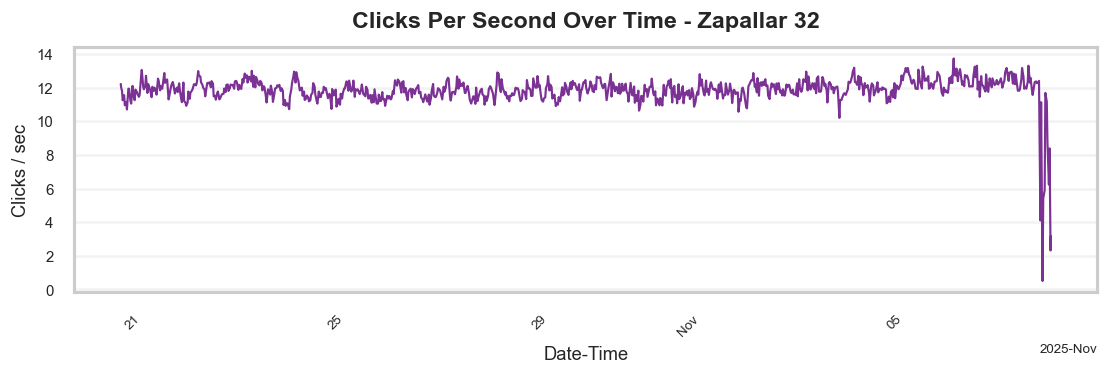

/var/folders/98/p03nljld21n2xrkp6cmfsv6w0000gn/T/ipykernel_64793/42737468.py:66: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plot_data.set_index("Time")["Clicks_Per_Sec"]


Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Sites results/Graphs/clickrate_zapallar_32_hp2000_env2p5_der2p5_tmin0p03_clicks_per_sec_hourly_mean.png


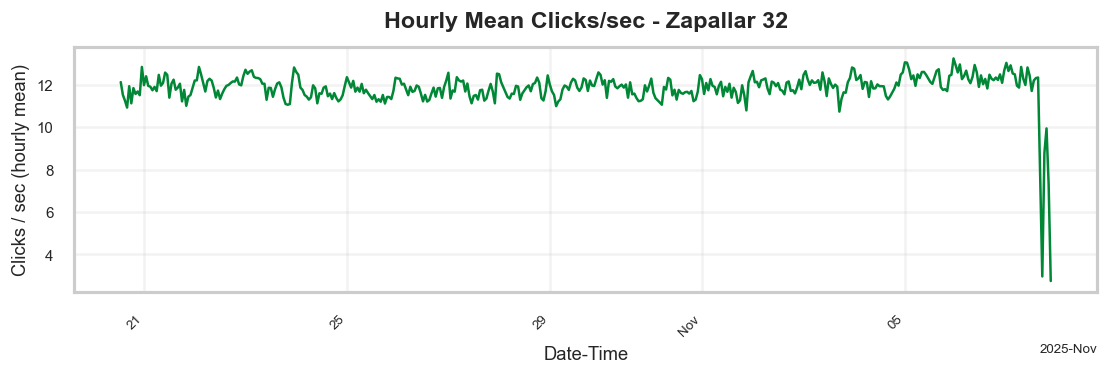

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Sites results/Graphs/clickrate_zapallar_32_hp2000_env2p5_der2p5_tmin0p03_summary_stats.csv


In [7]:
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update(
    {
        "figure.dpi": 120,
        "savefig.dpi": 200,
        "axes.titlepad": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 9,
        "grid.alpha": 0.25,
    }
)

SHOW_PLOTS_INLINE = True

plot_data = all_results.copy()
plot_data["Time"] = pd.to_datetime(plot_data["Time"], utc=True, errors="coerce")
if plot_data["Time"].isna().any():
    plot_data["Time"] = pd.to_datetime(plot_data["Time"], errors="coerce")
if plot_data["Time"].isna().any():
    raise RuntimeError("Could not parse Time column for plotting")

graphs_dir = Path(output_dir) / "Graphs"
graphs_dir.mkdir(parents=True, exist_ok=True)
base = Path(out_csv).stem

def _single_timeseries(y_col: str, y_label: str, title: str, filename: str, ylim=None, color="#1f77b4"):
    fig, ax = plt.subplots(figsize=(11, 3))
    ax.plot(plot_data["Time"], plot_data[y_col], linewidth=1.3, color=color)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Date-Time")
    ax.set_ylabel(y_label)

    locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    fig.autofmt_xdate(rotation=45)

    if ylim is not None:
        ax.set_ylim(ylim)

    ax.grid(True, axis="y")
    ax.grid(False, axis="x")

    out_path = graphs_dir / filename
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)

    if SHOW_PLOTS_INLINE:
        display(fig)

    plt.close(fig)

_single_timeseries(
    y_col="Clicks_Per_Sec",
    y_label="Clicks / sec",
    title=f"Clicks Per Second Over Time - {site_label}",
    filename=f"{base}_clicks_per_sec.png",
    ylim=None,
    color="#7B3294",
)

# Optional: hourly mean CPS plot
hourly = (
    plot_data.set_index("Time")["Clicks_Per_Sec"]
    .resample("1H")
    .mean()
    .dropna()
)
if not hourly.empty:
    fig, ax = plt.subplots(figsize=(11, 3))
    ax.plot(hourly.index, hourly.values, linewidth=1.5, color="#008837")
    ax.set_title(f"Hourly Mean Clicks/sec - {site_label}", fontweight="bold")
    ax.set_xlabel("Date-Time")
    ax.set_ylabel("Clicks / sec (hourly mean)")

    locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    fig.autofmt_xdate(rotation=45)

    out_path = graphs_dir / f"{base}_clicks_per_sec_hourly_mean.png"
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)
    if SHOW_PLOTS_INLINE:
        display(fig)
    plt.close(fig)

# Save summary stats for convenience
summary_path = graphs_dir / f"{base}_summary_stats.csv"
summary_stats.to_csv(summary_path, index=False)
print("Saved:", summary_path)
